In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
from sklearn import preprocessing

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
df = pd.read_excel('imputed_cs_no_outliers.xlsx')

In [5]:
df.index = df['Name']

In [6]:
df = df.drop('Name', axis=1)

In [7]:
columns = list(df.columns)

In [8]:
X = np.array(df[columns[1:]])
y = np.array(df[columns[0]])

In [481]:
X_scaled = preprocessing.scale(X)
y_scaled = preprocessing.scale(y)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
test_size=0.25, random_state=0)#Деление выборку на обучающую и тестовую в пропорции 3:1.
scoring = make_scorer(mean_squared_error, greater_is_better = False)

Сохраним часть данных о фармацевтических компаниях для тестирования

In [487]:
df2 = df[100:]
y2 = df2[columns[0]]
X2 = df2[columns[1:]]
X2_scaled = preprocessing.scale(X2)
y2_scaled = preprocessing.scale(y2)

Загрузим данные об изменениях в потреблении домохозяйств

In [488]:
df_macro = pd.read_excel('macro_data.xlsx')
columns_m = df_macro.columns

In [489]:
ym = df_macro[columns_m[0]]
Xm = df_macro[columns_m[1:]]

In [490]:
Xm_scaled = preprocessing.scale(Xm)
ym_scaled = preprocessing.scale(ym)

# Применение AdaBoost

In [57]:
parameters_AdaBoost = {'learning_rate' : (0.01, 0.05, 0.1, 0.15),
                       'n_estimators' : range(10, 200, 40)}
g_cv_AdaBoost = GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(max_depth=4, max_features = 4, 
                                                                      min_samples_leaf = 5),loss = 'exponential'),
              param_grid=parameters_AdaBoost,scoring=scoring,
               cv=4, n_jobs = -1, refit=True, return_train_score = True, iid=True)
g_cv_AdaBoost.fit(X_train, y_train)#Обучение модели
print('Оптимальные параметры:', g_cv_AdaBoost.best_params_)
result = g_cv_AdaBoost.cv_results_ #Результаты для всех рассмотренных параметров
print(-1*pd.DataFrame(g_cv_AdaBoost.cv_results_)['mean_test_score'].max(), ' - минимальное MSE')

Оптимальные параметры: {'learning_rate': 0.15, 'n_estimators': 170}
5.337261157703476  - минимальное MSE


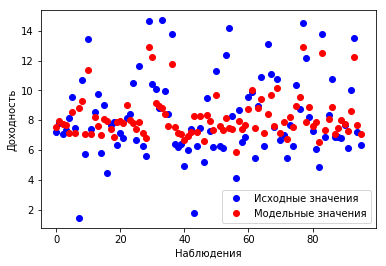

In [171]:
plt.plot(y, 'bo')
plt.plot(g_cv_AdaBoost.best_estimator_.predict(X), 'ro')
plt.xlabel('Наблюдения')
plt.ylabel('Доходность')
plt.legend(['Исходные значения', 'Модельные значения'])
plt.show()

In [172]:
best_AB = g_cv_AdaBoost.best_estimator_

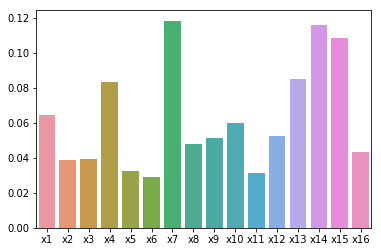

In [173]:
sns.barplot(x= df.columns[1:], y=best_AB.feature_importances_)

In [182]:
best_AB.feature_importances_

array([0.06423517, 0.03855754, 0.03925269, 0.08316582, 0.03270363,
       0.02894728, 0.11823839, 0.04770879, 0.05152065, 0.05955266,
       0.03123143, 0.05247429, 0.08520098, 0.1157325 , 0.10822702,
       0.04325117])

In [39]:
AB_features = pd.DataFrame([df.columns[1:],best_AB.feature_importances_]).T
AB_features.columns = ['Переменная', 'feature importance']
AB_features.index = AB_features['Переменная']
AB_features = AB_features.drop('Переменная', axis=1)
AB_features.to_excel('AB_training_feature_importance.xlsx')

Проверим на новых данных о фармацевтических компаниях

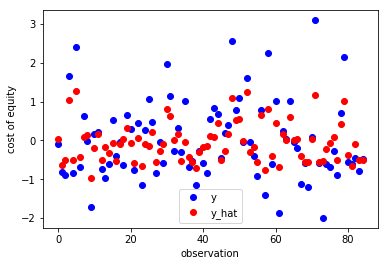

In [493]:
plt.plot(y2_scaled, 'bo')
plt.plot(g_cv_AdaBoost.best_estimator_.predict(X2_scaled), 'ro')
plt.xlabel('observation')
plt.ylabel('cost of equity')
plt.legend(['y', 'y_hat'])
plt.show()

Проверим на макроэкономических данных об изменении потреблении домохозяйств

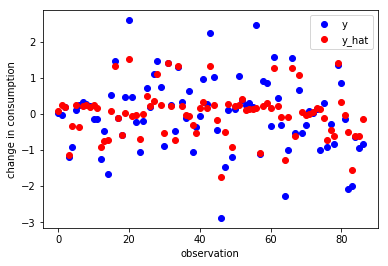

In [618]:
macro_model = g_cv_AdaBoost.best_estimator_.fit(Xm_scaled, ym_scaled)
plt.plot(ym_scaled, 'bo')
plt.plot(macro_model.predict(Xm_scaled), 'ro')
plt.xlabel('observation')
plt.ylabel('change in consumption')
plt.legend(['y', 'y_hat'])
plt.show()

In [620]:
mean_squared_error(ym_scaled, macro_model.predict(Xm_scaled))

0.2935382699730781

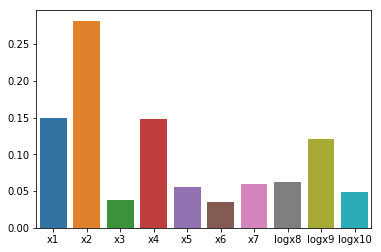

In [506]:
sns.barplot(x= df_macro.columns[1:], y=g_cv_AdaBoost.best_estimator_.fit(Xm_scaled, ym_scaled).feature_importances_)

# Применение градиентного бустинга

In [76]:
parameters_GBoost = {'learning_rate' : (0.01, 0.05, 0.1),
                    'n_estimators': range(30, 111, 20),
                    'min_samples_split': range(2, 10, 4),
                     'max_depth': range(3, 7)}
g_cv_GBoost = GridSearchCV(GradientBoostingRegressor(min_samples_leaf = 5, max_features=4),
              param_grid=parameters_GBoost,scoring=scoring,
               cv=10, n_jobs = -1, refit=True, return_train_score = True, iid=True)
g_cv_GBoost.fit(X_train, y_train)#Обучение модели
print('Оптимальные параметры:', g_cv_GBoost.best_params_)
result = g_cv_GBoost.cv_results_ #Результаты для всех рассмотренных параметров
print(-1*pd.DataFrame(g_cv_GBoost.cv_results_)['mean_test_score'].max(), ' - минимальное MSE')

Оптимальные параметры: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_split': 6, 'n_estimators': 90}
4.590713464054339  - минимальное MSE


In [77]:
best_GB = g_cv_GBoost.best_estimator_

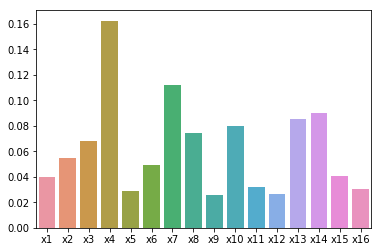

In [184]:
sns.barplot(x= df.columns[1:], y=g_cv_GBoost.best_estimator_.fit(X, y).feature_importances_)

In [185]:
g_cv_GBoost.best_estimator_.fit(X, y).feature_importances_

array([0.02765307, 0.027743  , 0.06044812, 0.14814042, 0.03613185,
       0.05874556, 0.10760123, 0.1033157 , 0.03467705, 0.04060043,
       0.07695167, 0.03387004, 0.12151422, 0.06420742, 0.01976095,
       0.03863929])

In [175]:
best_GB

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=4,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=90, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

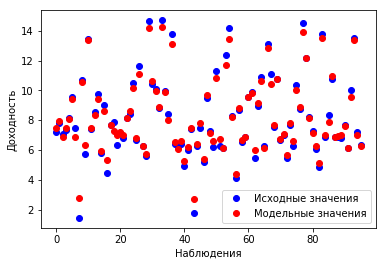

In [177]:
plt.plot(y, 'bo')
plt.plot(g_cv_GBoost.best_estimator_.predict(X), 'ro')
plt.xlabel('Наблюдения')
plt.ylabel('Доходность')
plt.legend(['Исходные значения', 'Модельные значения'])
plt.show()

In [44]:
plt.plot(y2_scaled, 'bo')
plt.plot(g_cv_GBoost.best_estimator_.predict(X2_scaled), 'ro')
plt.xlabel('observation')
plt.ylabel('cost of equity')
plt.legend(['y', 'y_hat'])
plt.show()

NameError: name 'y2_scaled' is not defined

In [616]:
mean_squared_error(y2_scaled, g_cv_GBoost.best_estimator_.predict(X2_scaled))

1.0768687957444139

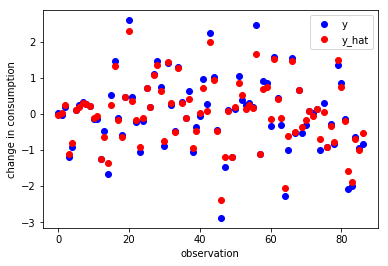

In [617]:
plt.plot(ym_scaled, 'bo')
plt.plot(g_cv_GBoost.best_estimator_.fit(Xm_scaled, ym_scaled).predict(Xm_scaled), 'ro')
plt.xlabel('observation')
plt.ylabel('change in consumption')
plt.legend(['y', 'y_hat'])
plt.show()

In [647]:
mean_squared_error(ym_scaled, g_cv_GBoost.best_estimator_.predict(Xm_scaled))

0.028581394976855135

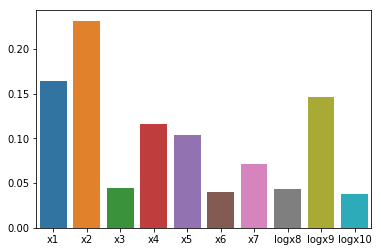

In [642]:
sns.barplot(x= df_macro.columns[1:], y=g_cv_GBoost.best_estimator_.fit(Xm_scaled, ym_scaled).feature_importances_)

# Применение catboost:

Список параметров: https://catboost.ai/docs/concepts/python-reference_parameters-list.html#python-reference_parameters-list

In [104]:
parameters = {'learning_rate':(0.01, 0.05, 0.1, 0.2, 0.3)}
g_cv = GridSearchCV(CatBoostRegressor(loss_function = 'RMSE', eval_metric = 'RMSE', rsm=0.25,
                                      random_state=0, leaf_estimation_method='Gradient', grow_policy='SymmetricTree'),
              param_grid=parameters,scoring=scoring,
               cv=4, n_jobs = -1, refit=True, iid=True, return_train_score=True)
g_cv.fit(X_train, y_train)#Обучение модели
print('Оптимальные параметры:', g_cv.best_params_)
result = g_cv.cv_results_ #Результаты для всех рассмотренных параметров
print(-1*pd.DataFrame(g_cv.cv_results_)['mean_test_score'].min(), ' - минимальное MSE')

0:	learn: 8.1689841	total: 3.46ms	remaining: 3.46s
1:	learn: 7.8702331	total: 10.6ms	remaining: 5.31s
2:	learn: 7.6201857	total: 16.9ms	remaining: 5.62s
3:	learn: 7.3230090	total: 25.1ms	remaining: 6.26s
4:	learn: 7.1370484	total: 28.5ms	remaining: 5.67s
5:	learn: 6.9067649	total: 35.9ms	remaining: 5.95s
6:	learn: 6.7306040	total: 42.8ms	remaining: 6.07s
7:	learn: 6.5068212	total: 45.4ms	remaining: 5.63s
8:	learn: 6.3117355	total: 49ms	remaining: 5.4s
9:	learn: 6.1256367	total: 58.3ms	remaining: 5.77s
10:	learn: 5.9613785	total: 71ms	remaining: 6.39s
11:	learn: 5.8115669	total: 78.3ms	remaining: 6.45s
12:	learn: 5.6474791	total: 85.6ms	remaining: 6.5s
13:	learn: 5.4945935	total: 92.4ms	remaining: 6.5s
14:	learn: 5.3230259	total: 95.8ms	remaining: 6.29s
15:	learn: 5.1694460	total: 103ms	remaining: 6.35s
16:	learn: 5.0358563	total: 121ms	remaining: 6.98s
17:	learn: 4.8995713	total: 128ms	remaining: 6.96s
18:	learn: 4.7539533	total: 131ms	remaining: 6.75s
19:	learn: 4.6147082	total: 138ms

180:	learn: 1.4258745	total: 1.38s	remaining: 6.23s
181:	learn: 1.4255266	total: 1.4s	remaining: 6.28s
182:	learn: 1.4219969	total: 1.4s	remaining: 6.26s
183:	learn: 1.4207998	total: 1.41s	remaining: 6.26s
184:	learn: 1.4203330	total: 1.42s	remaining: 6.25s
185:	learn: 1.4196816	total: 1.42s	remaining: 6.22s
186:	learn: 1.4192362	total: 1.43s	remaining: 6.21s
187:	learn: 1.4174597	total: 1.45s	remaining: 6.25s
188:	learn: 1.4170314	total: 1.45s	remaining: 6.24s
189:	learn: 1.4169314	total: 1.46s	remaining: 6.22s
190:	learn: 1.4151177	total: 1.46s	remaining: 6.2s
191:	learn: 1.4142968	total: 1.47s	remaining: 6.19s
192:	learn: 1.4125595	total: 1.48s	remaining: 6.18s
193:	learn: 1.4122397	total: 1.49s	remaining: 6.2s
194:	learn: 1.4121943	total: 1.5s	remaining: 6.19s
195:	learn: 1.4117814	total: 1.5s	remaining: 6.16s
196:	learn: 1.4115403	total: 1.51s	remaining: 6.15s
197:	learn: 1.4110998	total: 1.51s	remaining: 6.13s
198:	learn: 1.4110896	total: 1.52s	remaining: 6.12s
199:	learn: 1.4067

358:	learn: 1.2666909	total: 2.76s	remaining: 4.92s
359:	learn: 1.2665859	total: 2.77s	remaining: 4.93s
360:	learn: 1.2656129	total: 2.78s	remaining: 4.91s
361:	learn: 1.2652315	total: 2.78s	remaining: 4.91s
362:	learn: 1.2649726	total: 2.79s	remaining: 4.89s
363:	learn: 1.2649721	total: 2.79s	remaining: 4.88s
364:	learn: 1.2649034	total: 2.79s	remaining: 4.86s
365:	learn: 1.2648267	total: 2.8s	remaining: 4.85s
366:	learn: 1.2647036	total: 2.8s	remaining: 4.83s
367:	learn: 1.2646810	total: 2.8s	remaining: 4.82s
368:	learn: 1.2551085	total: 2.82s	remaining: 4.82s
369:	learn: 1.2550252	total: 2.83s	remaining: 4.81s
370:	learn: 1.2550045	total: 2.83s	remaining: 4.8s
371:	learn: 1.2549429	total: 2.84s	remaining: 4.79s
372:	learn: 1.2548154	total: 2.85s	remaining: 4.79s
373:	learn: 1.2547897	total: 2.87s	remaining: 4.8s
374:	learn: 1.2547458	total: 2.87s	remaining: 4.79s
375:	learn: 1.2546036	total: 2.88s	remaining: 4.78s
376:	learn: 1.2507681	total: 2.88s	remaining: 4.77s
377:	learn: 1.250

518:	learn: 1.0945559	total: 3.94s	remaining: 3.65s
519:	learn: 1.0945123	total: 3.95s	remaining: 3.65s
520:	learn: 1.0944798	total: 3.96s	remaining: 3.64s
521:	learn: 1.0944355	total: 3.97s	remaining: 3.63s
522:	learn: 1.0892116	total: 3.98s	remaining: 3.63s
523:	learn: 1.0891631	total: 3.98s	remaining: 3.61s
524:	learn: 1.0886937	total: 3.99s	remaining: 3.61s
525:	learn: 1.0857714	total: 4s	remaining: 3.6s
526:	learn: 1.0856189	total: 4.01s	remaining: 3.6s
527:	learn: 1.0854697	total: 4.01s	remaining: 3.59s
528:	learn: 1.0794819	total: 4.02s	remaining: 3.58s
529:	learn: 1.0697641	total: 4.03s	remaining: 3.57s
530:	learn: 1.0695048	total: 4.03s	remaining: 3.56s
531:	learn: 1.0693410	total: 4.05s	remaining: 3.56s
532:	learn: 1.0667156	total: 4.05s	remaining: 3.55s
533:	learn: 1.0667156	total: 4.05s	remaining: 3.54s
534:	learn: 1.0665468	total: 4.06s	remaining: 3.53s
535:	learn: 1.0665070	total: 4.07s	remaining: 3.52s
536:	learn: 1.0664451	total: 4.07s	remaining: 3.51s
537:	learn: 1.066

694:	learn: 0.8818060	total: 5.31s	remaining: 2.33s
695:	learn: 0.8817956	total: 5.32s	remaining: 2.32s
696:	learn: 0.8768437	total: 5.33s	remaining: 2.31s
697:	learn: 0.8768187	total: 5.33s	remaining: 2.31s
698:	learn: 0.8741366	total: 5.34s	remaining: 2.3s
699:	learn: 0.8739324	total: 5.34s	remaining: 2.29s
700:	learn: 0.8730944	total: 5.35s	remaining: 2.28s
701:	learn: 0.8730694	total: 5.36s	remaining: 2.27s
702:	learn: 0.8730651	total: 5.36s	remaining: 2.27s
703:	learn: 0.8680762	total: 5.37s	remaining: 2.26s
704:	learn: 0.8677122	total: 5.37s	remaining: 2.25s
705:	learn: 0.8637510	total: 5.38s	remaining: 2.24s
706:	learn: 0.8634989	total: 5.39s	remaining: 2.23s
707:	learn: 0.8629159	total: 5.39s	remaining: 2.22s
708:	learn: 0.8628694	total: 5.41s	remaining: 2.22s
709:	learn: 0.8628541	total: 5.42s	remaining: 2.21s
710:	learn: 0.8596745	total: 5.42s	remaining: 2.2s
711:	learn: 0.8596298	total: 5.43s	remaining: 2.19s
712:	learn: 0.8595582	total: 5.43s	remaining: 2.19s
713:	learn: 0.

854:	learn: 0.7733329	total: 6.68s	remaining: 1.13s
855:	learn: 0.7694579	total: 6.68s	remaining: 1.12s
856:	learn: 0.7694267	total: 6.69s	remaining: 1.12s
857:	learn: 0.7694007	total: 6.7s	remaining: 1.11s
858:	learn: 0.7694001	total: 6.71s	remaining: 1.1s
859:	learn: 0.7693993	total: 6.71s	remaining: 1.09s
860:	learn: 0.7693545	total: 6.72s	remaining: 1.08s
861:	learn: 0.7693200	total: 6.73s	remaining: 1.08s
862:	learn: 0.7691290	total: 6.73s	remaining: 1.07s
863:	learn: 0.7690964	total: 6.74s	remaining: 1.06s
864:	learn: 0.7690541	total: 6.75s	remaining: 1.05s
865:	learn: 0.7690532	total: 6.75s	remaining: 1.04s
866:	learn: 0.7688975	total: 6.76s	remaining: 1.04s
867:	learn: 0.7687981	total: 6.78s	remaining: 1.03s
868:	learn: 0.7686110	total: 6.78s	remaining: 1.02s
869:	learn: 0.7686077	total: 6.79s	remaining: 1.01s
870:	learn: 0.7686073	total: 6.79s	remaining: 1s
871:	learn: 0.7664980	total: 6.81s	remaining: 1000ms
872:	learn: 0.7636234	total: 6.82s	remaining: 992ms
873:	learn: 0.76

In [9]:
from catboost import Pool, cv
cv_data = X
labels = y
cv_dataset = Pool(data=cv_data,
                  label=labels)
params = {"iterations": 427,
          'depth': 2,
          'learning_rate': 0.05,
          'eval_metric':'MAPE',
          "loss_function": "RMSE",
          "verbose": False}
scores = cv(cv_dataset,
            params,
            fold_count=4, 
            plot="False")
scores['test-RMSE-mean'].min()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2.5833381254620615

In [25]:
catboost_model = CatBoostRegressor(iterations = 427, depth=2, learning_rate=0.05, eval_metric='MAPE',loss_function='RMSE', verbose=False)

In [34]:
catboost_model.fit(X=cv_data, y=labels)

In [40]:
y_cb_hat = catboost_model.predict( 
                 cv_data, 
                 verbose = False, 
                 thread_count = -1)

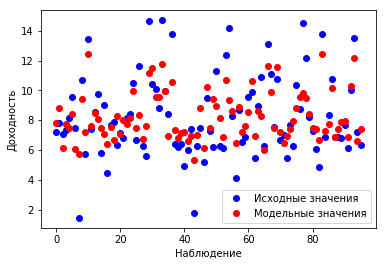

In [42]:
plt.plot(y, 'bo')
plt.plot(y_cb_hat, 'ro')
plt.xlabel('Наблюдение')
plt.ylabel('Доходность')
plt.legend(['Исходные значения', 'Модельные значения'])
plt.show()

In [179]:
scores['test-RMSE-mean'].min()**2

6.673635870465838

In [180]:
scores[scores['test-RMSE-mean'] == scores['test-RMSE-mean'].min()]

,iterations,test-MAPE-mean,test-MAPE-std,train-MAPE-mean,train-MAPE-std,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
426,426,0.330107,0.152,0.159856,0.016197,2.583338,0.539753,1.33309,0.11818


In [23]:
best_CatBoost = g_cv.best_estimator_

In [186]:
best_CatBoost.feature_importances_

array([ 2.54498526,  8.15914665,  7.566009  ,  7.45219385,  3.46814658,
        4.60372325,  7.157336  ,  8.03188962,  2.17337552, 13.57377154,
        5.64071984,  7.53707967,  5.24784605,  6.28679713,  5.37093738,
        5.18604265])

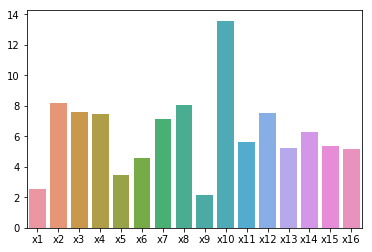

In [181]:
sns.barplot(x= df.columns[1:], y=best_CatBoost.feature_importances_)

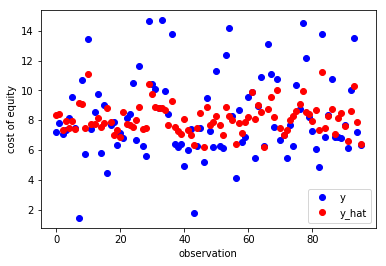

In [30]:
plt.plot(y, 'bo')
plt.plot(best_CatBoost.predict(X), 'ro')
plt.xlabel('observation')
plt.ylabel('cost of equity')
plt.legend(['y', 'y_hat'])
plt.show()

Проверим на новых данных из датасета фармацевтических компаний

0:	learn: 0.0348003	total: 3.9ms	remaining: 1.94s
1:	learn: 0.0842163	total: 8.64ms	remaining: 2.15s
2:	learn: 0.1267362	total: 17ms	remaining: 2.82s
3:	learn: 0.1414338	total: 20.2ms	remaining: 2.5s
4:	learn: 0.1663482	total: 22.6ms	remaining: 2.24s
5:	learn: 0.1890382	total: 29.8ms	remaining: 2.46s
6:	learn: 0.2167620	total: 32.3ms	remaining: 2.27s
7:	learn: 0.2273551	total: 37ms	remaining: 2.27s
8:	learn: 0.2590425	total: 39.5ms	remaining: 2.15s
9:	learn: 0.2641514	total: 41.6ms	remaining: 2.04s
10:	learn: 0.2863446	total: 46.6ms	remaining: 2.07s
11:	learn: 0.3087742	total: 50.7ms	remaining: 2.06s
12:	learn: 0.3249041	total: 56.5ms	remaining: 2.12s
13:	learn: 0.3424724	total: 61.8ms	remaining: 2.15s
14:	learn: 0.3563405	total: 64.3ms	remaining: 2.08s
15:	learn: 0.3733235	total: 69.4ms	remaining: 2.1s
16:	learn: 0.3853837	total: 72.1ms	remaining: 2.05s
17:	learn: 0.3853867	total: 78ms	remaining: 2.09s
18:	learn: 0.3967703	total: 80.2ms	remaining: 2.03s
19:	learn: 0.4070051	total: 84.

180:	learn: 0.9242625	total: 967ms	remaining: 1.7s
181:	learn: 0.9249461	total: 976ms	remaining: 1.71s
182:	learn: 0.9251673	total: 987ms	remaining: 1.71s
183:	learn: 0.9264010	total: 995ms	remaining: 1.71s
184:	learn: 0.9265992	total: 1s	remaining: 1.71s
185:	learn: 0.9277584	total: 1.01s	remaining: 1.71s
186:	learn: 0.9286755	total: 1.03s	remaining: 1.72s
187:	learn: 0.9293567	total: 1.04s	remaining: 1.72s
188:	learn: 0.9301465	total: 1.04s	remaining: 1.72s
189:	learn: 0.9302625	total: 1.05s	remaining: 1.71s
190:	learn: 0.9304372	total: 1.06s	remaining: 1.72s
191:	learn: 0.9304851	total: 1.07s	remaining: 1.72s
192:	learn: 0.9309912	total: 1.08s	remaining: 1.71s
193:	learn: 0.9317394	total: 1.08s	remaining: 1.71s
194:	learn: 0.9320740	total: 1.09s	remaining: 1.71s
195:	learn: 0.9321081	total: 1.1s	remaining: 1.7s
196:	learn: 0.9321207	total: 1.11s	remaining: 1.7s
197:	learn: 0.9321208	total: 1.11s	remaining: 1.7s
198:	learn: 0.9324370	total: 1.12s	remaining: 1.69s
199:	learn: 0.932480

373:	learn: 0.9746324	total: 2.31s	remaining: 777ms
374:	learn: 0.9746326	total: 2.31s	remaining: 770ms
375:	learn: 0.9746482	total: 2.32s	remaining: 764ms
376:	learn: 0.9748707	total: 2.33s	remaining: 759ms
377:	learn: 0.9753565	total: 2.33s	remaining: 751ms
378:	learn: 0.9754541	total: 2.33s	remaining: 746ms
379:	learn: 0.9756025	total: 2.34s	remaining: 740ms
380:	learn: 0.9757331	total: 2.35s	remaining: 734ms
381:	learn: 0.9757382	total: 2.35s	remaining: 727ms
382:	learn: 0.9763289	total: 2.36s	remaining: 720ms
383:	learn: 0.9764753	total: 2.36s	remaining: 713ms
384:	learn: 0.9764864	total: 2.37s	remaining: 707ms
385:	learn: 0.9767539	total: 2.37s	remaining: 700ms
386:	learn: 0.9772220	total: 2.38s	remaining: 694ms
387:	learn: 0.9772354	total: 2.38s	remaining: 687ms
388:	learn: 0.9772425	total: 2.38s	remaining: 680ms
389:	learn: 0.9773422	total: 2.39s	remaining: 674ms
390:	learn: 0.9773803	total: 2.39s	remaining: 667ms
391:	learn: 0.9776861	total: 2.39s	remaining: 659ms
392:	learn: 

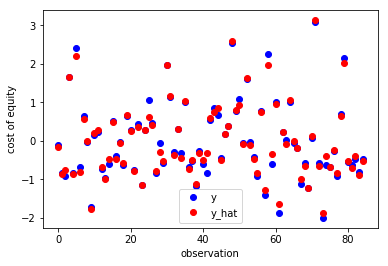

In [638]:
plt.plot(y2_scaled, 'bo')
plt.plot(g_cv.best_estimator_.fit(X2_scaled, y2_scaled).predict(X2_scaled), 'ro')
plt.xlabel('observation')
plt.ylabel('cost of equity')
plt.legend(['y', 'y_hat'])
plt.show()

In [636]:
mean_squared_error(y2_scaled, best_CatBoost.fit(X2_scaled, y2_scaled).predict(X2_scaled))

0:	learn: 0.0348003	total: 6.88ms	remaining: 3.44s
1:	learn: 0.0842163	total: 12.2ms	remaining: 3.04s
2:	learn: 0.1267362	total: 19.4ms	remaining: 3.21s
3:	learn: 0.1414338	total: 21.9ms	remaining: 2.71s
4:	learn: 0.1663482	total: 26.8ms	remaining: 2.65s
5:	learn: 0.1890382	total: 34ms	remaining: 2.8s
6:	learn: 0.2167620	total: 38.7ms	remaining: 2.72s
7:	learn: 0.2273551	total: 45.2ms	remaining: 2.78s
8:	learn: 0.2590425	total: 47.7ms	remaining: 2.6s
9:	learn: 0.2641514	total: 52.1ms	remaining: 2.55s
10:	learn: 0.2863446	total: 59ms	remaining: 2.62s
11:	learn: 0.3087742	total: 65.5ms	remaining: 2.66s
12:	learn: 0.3249041	total: 68.7ms	remaining: 2.57s
13:	learn: 0.3424724	total: 73.8ms	remaining: 2.56s
14:	learn: 0.3563405	total: 76.4ms	remaining: 2.47s
15:	learn: 0.3733235	total: 81.8ms	remaining: 2.47s
16:	learn: 0.3853837	total: 84.4ms	remaining: 2.4s
17:	learn: 0.3853867	total: 88.8ms	remaining: 2.38s
18:	learn: 0.3967703	total: 91.1ms	remaining: 2.31s
19:	learn: 0.4070051	total: 9

172:	learn: 0.9212167	total: 759ms	remaining: 1.44s
173:	learn: 0.9217696	total: 765ms	remaining: 1.43s
174:	learn: 0.9223339	total: 769ms	remaining: 1.43s
175:	learn: 0.9226887	total: 779ms	remaining: 1.43s
176:	learn: 0.9227761	total: 783ms	remaining: 1.43s
177:	learn: 0.9227761	total: 786ms	remaining: 1.42s
178:	learn: 0.9231730	total: 789ms	remaining: 1.42s
179:	learn: 0.9242624	total: 796ms	remaining: 1.41s
180:	learn: 0.9242625	total: 801ms	remaining: 1.41s
181:	learn: 0.9249461	total: 803ms	remaining: 1.4s
182:	learn: 0.9251673	total: 807ms	remaining: 1.4s
183:	learn: 0.9264010	total: 810ms	remaining: 1.39s
184:	learn: 0.9265992	total: 813ms	remaining: 1.38s
185:	learn: 0.9277584	total: 818ms	remaining: 1.38s
186:	learn: 0.9286755	total: 821ms	remaining: 1.37s
187:	learn: 0.9293567	total: 826ms	remaining: 1.37s
188:	learn: 0.9301465	total: 829ms	remaining: 1.36s
189:	learn: 0.9302625	total: 831ms	remaining: 1.36s
190:	learn: 0.9304372	total: 837ms	remaining: 1.35s
191:	learn: 0.

335:	learn: 0.9704231	total: 1.7s	remaining: 830ms
336:	learn: 0.9704283	total: 1.71s	remaining: 825ms
337:	learn: 0.9708961	total: 1.72s	remaining: 822ms
338:	learn: 0.9712068	total: 1.72s	remaining: 817ms
339:	learn: 0.9713109	total: 1.73s	remaining: 814ms
340:	learn: 0.9713452	total: 1.73s	remaining: 808ms
341:	learn: 0.9713523	total: 1.74s	remaining: 805ms
342:	learn: 0.9713528	total: 1.75s	remaining: 800ms
343:	learn: 0.9715526	total: 1.75s	remaining: 794ms
344:	learn: 0.9716029	total: 1.76s	remaining: 790ms
345:	learn: 0.9716070	total: 1.77s	remaining: 788ms
346:	learn: 0.9717990	total: 1.77s	remaining: 782ms
347:	learn: 0.9717993	total: 1.78s	remaining: 777ms
348:	learn: 0.9721506	total: 1.79s	remaining: 773ms
349:	learn: 0.9722839	total: 1.79s	remaining: 767ms
350:	learn: 0.9727982	total: 1.79s	remaining: 762ms
351:	learn: 0.9728072	total: 1.8s	remaining: 756ms
352:	learn: 0.9731699	total: 1.8s	remaining: 751ms
353:	learn: 0.9733407	total: 1.81s	remaining: 745ms
354:	learn: 0.9

0.01377007507123279

Проверим на макроэкономических данных:

0:	learn: 0.0508051	total: 3.91ms	remaining: 1.95s
1:	learn: 0.0775501	total: 7.8ms	remaining: 1.94s
2:	learn: 0.1107280	total: 13.5ms	remaining: 2.24s
3:	learn: 0.1587050	total: 17.6ms	remaining: 2.18s
4:	learn: 0.1994983	total: 23.5ms	remaining: 2.32s
5:	learn: 0.2306261	total: 27.1ms	remaining: 2.23s
6:	learn: 0.2583248	total: 33.1ms	remaining: 2.33s
7:	learn: 0.2780308	total: 37.6ms	remaining: 2.31s
8:	learn: 0.3147665	total: 46.4ms	remaining: 2.53s
9:	learn: 0.3333820	total: 50.7ms	remaining: 2.48s
10:	learn: 0.3485451	total: 57.2ms	remaining: 2.54s
11:	learn: 0.3508685	total: 60.2ms	remaining: 2.45s
12:	learn: 0.3670168	total: 64.9ms	remaining: 2.43s
13:	learn: 0.3980264	total: 73.7ms	remaining: 2.56s
14:	learn: 0.4222562	total: 78.9ms	remaining: 2.55s
15:	learn: 0.4401216	total: 85ms	remaining: 2.57s
16:	learn: 0.4505870	total: 87.7ms	remaining: 2.49s
17:	learn: 0.4656358	total: 91.6ms	remaining: 2.45s
18:	learn: 0.4855561	total: 98.2ms	remaining: 2.49s
19:	learn: 0.4855629	tota

188:	learn: 0.9188178	total: 759ms	remaining: 1.25s
189:	learn: 0.9200144	total: 763ms	remaining: 1.24s
190:	learn: 0.9200150	total: 770ms	remaining: 1.25s
191:	learn: 0.9202485	total: 775ms	remaining: 1.24s
192:	learn: 0.9213207	total: 779ms	remaining: 1.24s
193:	learn: 0.9214541	total: 785ms	remaining: 1.24s
194:	learn: 0.9214655	total: 787ms	remaining: 1.23s
195:	learn: 0.9214898	total: 791ms	remaining: 1.23s
196:	learn: 0.9216072	total: 797ms	remaining: 1.23s
197:	learn: 0.9217673	total: 799ms	remaining: 1.22s
198:	learn: 0.9232018	total: 806ms	remaining: 1.22s
199:	learn: 0.9232019	total: 808ms	remaining: 1.21s
200:	learn: 0.9246503	total: 813ms	remaining: 1.21s
201:	learn: 0.9253620	total: 817ms	remaining: 1.21s
202:	learn: 0.9261886	total: 820ms	remaining: 1.2s
203:	learn: 0.9268546	total: 826ms	remaining: 1.2s
204:	learn: 0.9279948	total: 828ms	remaining: 1.19s
205:	learn: 0.9292332	total: 835ms	remaining: 1.19s
206:	learn: 0.9297847	total: 837ms	remaining: 1.18s
207:	learn: 0.

351:	learn: 0.9615064	total: 1.49s	remaining: 626ms
352:	learn: 0.9615952	total: 1.49s	remaining: 622ms
353:	learn: 0.9616444	total: 1.5s	remaining: 618ms
354:	learn: 0.9618222	total: 1.5s	remaining: 615ms
355:	learn: 0.9618579	total: 1.51s	remaining: 611ms
356:	learn: 0.9621169	total: 1.52s	remaining: 607ms
357:	learn: 0.9621638	total: 1.52s	remaining: 603ms
358:	learn: 0.9624380	total: 1.52s	remaining: 599ms
359:	learn: 0.9624659	total: 1.53s	remaining: 594ms
360:	learn: 0.9624659	total: 1.53s	remaining: 589ms
361:	learn: 0.9630401	total: 1.53s	remaining: 584ms
362:	learn: 0.9630417	total: 1.53s	remaining: 579ms
363:	learn: 0.9631236	total: 1.54s	remaining: 575ms
364:	learn: 0.9631236	total: 1.54s	remaining: 570ms
365:	learn: 0.9631247	total: 1.54s	remaining: 566ms
366:	learn: 0.9631251	total: 1.55s	remaining: 561ms
367:	learn: 0.9634405	total: 1.55s	remaining: 557ms
368:	learn: 0.9634867	total: 1.55s	remaining: 552ms
369:	learn: 0.9634924	total: 1.56s	remaining: 548ms
370:	learn: 0.

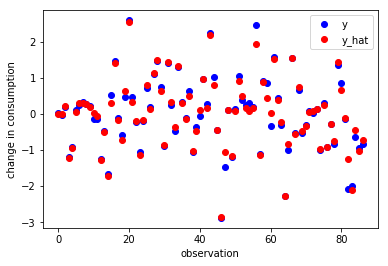

In [637]:
plt.plot(ym_scaled, 'bo')
plt.plot(g_cv.best_estimator_.fit(Xm_scaled, ym_scaled).predict(Xm_scaled), 'ro')
plt.xlabel('observation')
plt.ylabel('change in consumption')
plt.legend(['y', 'y_hat'])
plt.show()

In [646]:
mean_squared_error(ym_scaled, best_CatBoost.fit(Xm_scaled, ym_scaled).predict(Xm_scaled))

0:	learn: 0.0508051	total: 5.67ms	remaining: 2.83s
1:	learn: 0.0775501	total: 10.8ms	remaining: 2.69s
2:	learn: 0.1107280	total: 16.8ms	remaining: 2.79s
3:	learn: 0.1587050	total: 22.3ms	remaining: 2.76s
4:	learn: 0.1994983	total: 28.7ms	remaining: 2.85s
5:	learn: 0.2306261	total: 33.3ms	remaining: 2.74s
6:	learn: 0.2583248	total: 38.9ms	remaining: 2.74s
7:	learn: 0.2780308	total: 43.7ms	remaining: 2.69s
8:	learn: 0.3147665	total: 50.3ms	remaining: 2.74s
9:	learn: 0.3333820	total: 55.6ms	remaining: 2.72s
10:	learn: 0.3485451	total: 61ms	remaining: 2.71s
11:	learn: 0.3508685	total: 65.8ms	remaining: 2.67s
12:	learn: 0.3670168	total: 72.2ms	remaining: 2.71s
13:	learn: 0.3980264	total: 79.5ms	remaining: 2.76s
14:	learn: 0.4222562	total: 84.6ms	remaining: 2.73s
15:	learn: 0.4401216	total: 91.3ms	remaining: 2.76s
16:	learn: 0.4505870	total: 94ms	remaining: 2.67s
17:	learn: 0.4656358	total: 98.1ms	remaining: 2.63s
18:	learn: 0.4855561	total: 103ms	remaining: 2.62s
19:	learn: 0.4855629	total:

185:	learn: 0.9174646	total: 755ms	remaining: 1.27s
186:	learn: 0.9175348	total: 765ms	remaining: 1.28s
187:	learn: 0.9182467	total: 770ms	remaining: 1.28s
188:	learn: 0.9188178	total: 778ms	remaining: 1.28s
189:	learn: 0.9200144	total: 782ms	remaining: 1.28s
190:	learn: 0.9200150	total: 788ms	remaining: 1.27s
191:	learn: 0.9202485	total: 792ms	remaining: 1.27s
192:	learn: 0.9213207	total: 796ms	remaining: 1.26s
193:	learn: 0.9214541	total: 801ms	remaining: 1.26s
194:	learn: 0.9214655	total: 806ms	remaining: 1.26s
195:	learn: 0.9214898	total: 808ms	remaining: 1.25s
196:	learn: 0.9216072	total: 814ms	remaining: 1.25s
197:	learn: 0.9217673	total: 817ms	remaining: 1.25s
198:	learn: 0.9232018	total: 822ms	remaining: 1.24s
199:	learn: 0.9232019	total: 825ms	remaining: 1.24s
200:	learn: 0.9246503	total: 829ms	remaining: 1.23s
201:	learn: 0.9253620	total: 836ms	remaining: 1.23s
202:	learn: 0.9261886	total: 839ms	remaining: 1.23s
203:	learn: 0.9268546	total: 844ms	remaining: 1.23s
204:	learn: 

365:	learn: 0.9631247	total: 1.72s	remaining: 628ms
366:	learn: 0.9631251	total: 1.72s	remaining: 624ms
367:	learn: 0.9634405	total: 1.73s	remaining: 620ms
368:	learn: 0.9634867	total: 1.73s	remaining: 615ms
369:	learn: 0.9634924	total: 1.74s	remaining: 610ms
370:	learn: 0.9635246	total: 1.74s	remaining: 605ms
371:	learn: 0.9635695	total: 1.74s	remaining: 600ms
372:	learn: 0.9635772	total: 1.75s	remaining: 595ms
373:	learn: 0.9637981	total: 1.75s	remaining: 591ms
374:	learn: 0.9641597	total: 1.76s	remaining: 586ms
375:	learn: 0.9642589	total: 1.76s	remaining: 581ms
376:	learn: 0.9643067	total: 1.76s	remaining: 576ms
377:	learn: 0.9643227	total: 1.77s	remaining: 571ms
378:	learn: 0.9643457	total: 1.77s	remaining: 566ms
379:	learn: 0.9643720	total: 1.77s	remaining: 561ms
380:	learn: 0.9643805	total: 1.78s	remaining: 556ms
381:	learn: 0.9644878	total: 1.78s	remaining: 551ms
382:	learn: 0.9649857	total: 1.79s	remaining: 546ms
383:	learn: 0.9652541	total: 1.79s	remaining: 541ms
384:	learn: 

0.02365630913970871

0:	learn: 0.0508051	total: 15ms	remaining: 7.5s
1:	learn: 0.0775501	total: 21.8ms	remaining: 5.43s
2:	learn: 0.1107280	total: 31.7ms	remaining: 5.25s
3:	learn: 0.1587050	total: 38.5ms	remaining: 4.77s
4:	learn: 0.1994983	total: 44.8ms	remaining: 4.44s
5:	learn: 0.2306261	total: 50.8ms	remaining: 4.18s
6:	learn: 0.2583248	total: 56.4ms	remaining: 3.97s
7:	learn: 0.2780308	total: 62.3ms	remaining: 3.83s
8:	learn: 0.3147665	total: 67.2ms	remaining: 3.67s
9:	learn: 0.3333820	total: 70.6ms	remaining: 3.46s
10:	learn: 0.3485451	total: 75.7ms	remaining: 3.36s
11:	learn: 0.3508685	total: 78ms	remaining: 3.17s
12:	learn: 0.3670168	total: 81.4ms	remaining: 3.05s
13:	learn: 0.3980264	total: 86.8ms	remaining: 3.01s
14:	learn: 0.4222562	total: 93.6ms	remaining: 3.03s
15:	learn: 0.4401216	total: 99.5ms	remaining: 3.01s
16:	learn: 0.4505870	total: 103ms	remaining: 2.93s
17:	learn: 0.4656358	total: 107ms	remaining: 2.87s
18:	learn: 0.4855561	total: 114ms	remaining: 2.89s
19:	learn: 0.4855629	total: 11

163:	learn: 0.9063852	total: 569ms	remaining: 1.17s
164:	learn: 0.9072433	total: 574ms	remaining: 1.17s
165:	learn: 0.9089965	total: 579ms	remaining: 1.17s
166:	learn: 0.9090735	total: 585ms	remaining: 1.17s
167:	learn: 0.9092047	total: 589ms	remaining: 1.16s
168:	learn: 0.9095209	total: 594ms	remaining: 1.16s
169:	learn: 0.9105441	total: 596ms	remaining: 1.16s
170:	learn: 0.9109530	total: 599ms	remaining: 1.15s
171:	learn: 0.9109530	total: 602ms	remaining: 1.15s
172:	learn: 0.9109806	total: 603ms	remaining: 1.14s
173:	learn: 0.9110182	total: 608ms	remaining: 1.14s
174:	learn: 0.9110259	total: 611ms	remaining: 1.13s
175:	learn: 0.9126101	total: 615ms	remaining: 1.13s
176:	learn: 0.9134185	total: 619ms	remaining: 1.13s
177:	learn: 0.9135403	total: 623ms	remaining: 1.13s
178:	learn: 0.9148374	total: 628ms	remaining: 1.13s
179:	learn: 0.9161590	total: 630ms	remaining: 1.12s
180:	learn: 0.9161590	total: 633ms	remaining: 1.12s
181:	learn: 0.9162881	total: 637ms	remaining: 1.11s
182:	learn: 

338:	learn: 0.9602646	total: 1.32s	remaining: 628ms
339:	learn: 0.9603329	total: 1.33s	remaining: 626ms
340:	learn: 0.9603596	total: 1.33s	remaining: 623ms
341:	learn: 0.9603710	total: 1.34s	remaining: 620ms
342:	learn: 0.9605523	total: 1.35s	remaining: 618ms
343:	learn: 0.9606715	total: 1.35s	remaining: 615ms
344:	learn: 0.9606742	total: 1.36s	remaining: 611ms
345:	learn: 0.9608607	total: 1.36s	remaining: 607ms
346:	learn: 0.9609234	total: 1.37s	remaining: 602ms
347:	learn: 0.9610633	total: 1.37s	remaining: 599ms
348:	learn: 0.9611808	total: 1.37s	remaining: 595ms
349:	learn: 0.9611975	total: 1.38s	remaining: 591ms
350:	learn: 0.9614484	total: 1.38s	remaining: 586ms
351:	learn: 0.9615064	total: 1.39s	remaining: 583ms
352:	learn: 0.9615952	total: 1.39s	remaining: 578ms
353:	learn: 0.9616444	total: 1.39s	remaining: 574ms
354:	learn: 0.9618222	total: 1.4s	remaining: 570ms
355:	learn: 0.9618579	total: 1.4s	remaining: 566ms
356:	learn: 0.9621169	total: 1.4s	remaining: 563ms
357:	learn: 0.9

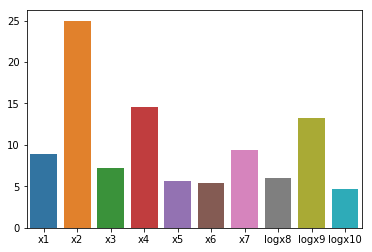

In [648]:
sns.barplot(x= df_macro.columns[1:], y=g_cv.best_estimator_.fit(Xm_scaled, ym_scaled).feature_importances_)